In [1]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sys
import os
from PIL import Image
import xml.etree.ElementTree as ET


In [2]:
def draw_rect(im, cords_, color = None):
    """Draw the rectangle on the image
    
    Parameters
    ----------
    
    im : numpy.ndarray
        numpy image 
    
    cords: numpy.ndarray
        Numpy array containing bounding boxes of shape `N X 4` where N is the 
        number of bounding boxes and the bounding boxes are represented in the
        format `x1 y1 x2 y2`
        
    Returns
    -------
    
    numpy.ndarray
        numpy image with bounding boxes drawn on it
        
    """
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255), (0, 255, 255), (128, 128, 0), (128, 0, 128)]
    if len(im.shape) == 2:
        im = cv2.cvtColor(im, cv2.COLOR_GRAY2RGB)
    im = im.copy()
    
    cords = cords_[:,:4]
    ids = cords_[:,4:]
    cords = cords.reshape(-1,4)
    for cord, id in zip(cords, ids):
        pt1, pt2 = (cord[0], cord[1]) , (cord[2], cord[3])
                
        pt1 = int(pt1[0]), int(pt1[1])
        pt2 = int(pt2[0]), int(pt2[1])
    
        im = cv2.rectangle(im.copy(), pt1, pt2, colors[int(id)], int(max(im.shape[:2])/400))
    
    plt.imshow(im)
    plt.show()

In [3]:
def bbox_area(bbox):
    return (bbox[:,2] - bbox[:,0])*(bbox[:,3] - bbox[:,1])

In [4]:
def clip_box(bbox, clip_box, alpha):
    """Clip the bounding boxes to the borders of an image
    
    Parameters
    ----------
    
    bbox: numpy.ndarray
        Numpy array containing bounding boxes of shape `N X 4` where N is the 
        number of bounding boxes and the bounding boxes are represented in the
        format `x1 y1 x2 y2`
    
    clip_box: numpy.ndarray
        An array of shape (4,) specifying the diagonal co-ordinates of the image
        The coordinates are represented in the format `x1 y1 x2 y2`
        
    alpha: float
        If the fraction of a bounding box left in the image after being clipped is 
        less than `alpha` the bounding box is dropped. 
    
    Returns
    -------
    
    numpy.ndarray
        Numpy array containing **clipped** bounding boxes of shape `N X 4` where N is the 
        number of bounding boxes left are being clipped and the bounding boxes are represented in the
        format `x1 y1 x2 y2` 
    
    """
    ar_ = (bbox_area(bbox))
    x_min = np.maximum(bbox[:,0], clip_box[0]).reshape(-1,1)
    y_min = np.maximum(bbox[:,1], clip_box[1]).reshape(-1,1)
    x_max = np.minimum(bbox[:,2], clip_box[2]).reshape(-1,1)
    y_max = np.minimum(bbox[:,3], clip_box[3]).reshape(-1,1)
    
    bbox = np.hstack((x_min, y_min, x_max, y_max, bbox[:,4:]))
    
    delta_area = ((ar_ - bbox_area(bbox))/ar_)
    
    mask = (delta_area < (1 - alpha)).astype(int)
    
    bbox = bbox[mask == 1,:]


    return bbox

In [5]:
def rotate_im(image, angle):
    """Rotate the image.
    
    Rotate the image such that the rotated image is enclosed inside the tightest
    rectangle. The area not occupied by the pixels of the original image is colored
    black. 
    
    Parameters
    ----------
    
    image : numpy.ndarray
        numpy image
    
    angle : float
        angle by which the image is to be rotated
    
    Returns
    -------
    
    numpy.ndarray
        Rotated Image
    
    """
    # grab the dimensions of the image and then determine the
    # centre
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)

    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    # perform the actual rotation and return the image
    image = cv2.warpAffine(image, M, (nW, nH))

#    image = cv2.resize(image, (w,h))
    return image

In [6]:
def get_corners(bboxes):
    
    """Get corners of bounding boxes
    
    Parameters
    ----------
    
    bboxes: numpy.ndarray
        Numpy array containing bounding boxes of shape `N X 4` where N is the 
        number of bounding boxes and the bounding boxes are represented in the
        format `x1 y1 x2 y2`
    
    returns
    -------
    
    numpy.ndarray
        Numpy array of shape `N x 8` containing N bounding boxes each described by their 
        corner co-ordinates `x1 y1 x2 y2 x3 y3 x4 y4`      
        
    """
    width = (bboxes[:,2] - bboxes[:,0]).reshape(-1,1)
    height = (bboxes[:,3] - bboxes[:,1]).reshape(-1,1)
    
    x1 = bboxes[:,0].reshape(-1,1)
    y1 = bboxes[:,1].reshape(-1,1)
    
    x2 = x1 + width
    y2 = y1 
    
    x3 = x1
    y3 = y1 + height
    
    x4 = bboxes[:,2].reshape(-1,1)
    y4 = bboxes[:,3].reshape(-1,1)
    
    corners = np.hstack((x1,y1,x2,y2,x3,y3,x4,y4))
    
    return corners

In [7]:
def rotate_box(corners,angle,  cx, cy, h, w):
    
    """Rotate the bounding box.
    
    
    Parameters
    ----------
    
    corners : numpy.ndarray
        Numpy array of shape `N x 8` containing N bounding boxes each described by their 
        corner co-ordinates `x1 y1 x2 y2 x3 y3 x4 y4`
    
    angle : float
        angle by which the image is to be rotated
        
    cx : int
        x coordinate of the center of image (about which the box will be rotated)
        
    cy : int
        y coordinate of the center of image (about which the box will be rotated)
        
    h : int 
        height of the image
        
    w : int 
        width of the image
    
    Returns
    -------
    
    numpy.ndarray
        Numpy array of shape `N x 8` containing N rotated bounding boxes each described by their 
        corner co-ordinates `x1 y1 x2 y2 x3 y3 x4 y4`
    """

    corners = corners.reshape(-1,2)
    corners = np.hstack((corners, np.ones((corners.shape[0],1), dtype = type(corners[0][0]))))
    
    M = cv2.getRotationMatrix2D((cx, cy), angle, 1.0)
    
    
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cx
    M[1, 2] += (nH / 2) - cy
    # Prepare the vector to be transformed
    calculated = np.dot(M,corners.T).T
    
    calculated = calculated.reshape(-1,8)
    
    return calculated

In [8]:
def get_enclosing_box(corners):
    """Get an enclosing box for ratated corners of a bounding box
    
    Parameters
    ----------
    
    corners : numpy.ndarray
        Numpy array of shape `N x 8` containing N bounding boxes each described by their 
        corner co-ordinates `x1 y1 x2 y2 x3 y3 x4 y4`  
    
    Returns 
    -------
    
    numpy.ndarray
        Numpy array containing enclosing bounding boxes of shape `N X 4` where N is the 
        number of bounding boxes and the bounding boxes are represented in the
        format `x1 y1 x2 y2`
        
    """
    x_ = corners[:,[0,2,4,6]]
    y_ = corners[:,[1,3,5,7]]
    
    xmin = np.min(x_,1).reshape(-1,1)
    ymin = np.min(y_,1).reshape(-1,1)
    xmax = np.max(x_,1).reshape(-1,1)
    ymax = np.max(y_,1).reshape(-1,1)
    
    final = np.hstack((xmin, ymin, xmax, ymax,corners[:,8:]))
    
    return final

In [9]:
def letterbox_image(img, inp_dim):
    '''resize image with unchanged aspect ratio using padding
    
    Parameters
    ----------
    
    img : numpy.ndarray
        Image 
    
    inp_dim: tuple(int)
        shape of the reszied image
        
    Returns
    -------
    
    numpy.ndarray:
        Resized image
    
    '''

    inp_dim = (inp_dim, inp_dim)
    img_w, img_h = img.shape[1], img.shape[0]
    w, h = inp_dim
    new_w = int(img_w * min(w/img_w, h/img_h))
    new_h = int(img_h * min(w/img_w, h/img_h))
    resized_image = cv2.resize(img, (new_w,new_h))
    
    canvas = np.full((inp_dim[1], inp_dim[0], 3), 0)

    canvas[(h-new_h)//2:(h-new_h)//2 + new_h,(w-new_w)//2:(w-new_w)//2 + new_w,  :] = resized_image
    
    return canvas

In [10]:
def get_info_bbox(xml_path, label_mapping):
    bboxes = []
    # Đọc nội dung của tệp XML
    xml_text = ET.parse(xml_path)
    root = xml_text.getroot()
    for obj in root.iter('object'):
        # Lấy tên lớp của đối tượng từ tệp XML
        class_name = obj.find('name').text
        try:
            # Tìm id của lớp từ label_mapping
            id_class = label_mapping[class_name]
        except:
            print('Not found class name: {}'.format(class_name))
        for bbox in obj.iter('bndbox'):
            # Lấy thông tin tọa độ của hộp giới hạn từ tệp XML
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)
            # Kiểm tra xem hộp giới hạn có kích thước hợp lệ không
            assert xmax > xmin and ymax > ymin, f"Box size error !: (xmin, ymin, xmax, ymax): {xmin, ymin, xmax, ymax}"
            # Thêm thông tin của hộp giới hạn và id lớp vào danh sách bboxes
            bboxes.append((xmin, ymin, xmax, ymax, id_class))
    # Chuyển danh sách bboxes thành mảng numpy với dtype là float32
    bboxes = np.array(bboxes, dtype=np.float32)
    return bboxes

In [11]:
label_mapping = {
        'dog': 0,
        'car':1,
        'bike':2,
    }

In [12]:
path_img = './assets/voc/sample.jpg'
img = cv2.imread(path_img)

path_xml = './assets/voc/sample.xml'
bboxes = get_info_bbox(path_xml, label_mapping)

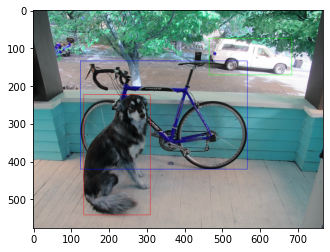

In [13]:
draw_rect(img.copy(), bboxes.copy())

In [14]:
p=1

In [15]:
class HorizontalFlip(object):

    """Randomly horizontally flips the Image with the probability *p*

    Parameters
    ----------
    p: float
        The probability with which the image is flipped


    Returns
    -------

    numpy.ndaaray
        Flipped image in the numpy format of shape `HxWxC`

    numpy.ndarray
        Tranformed bounding box co-ordinates of the format `n x 4` where n is
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box

    """

    def __init__(self):
        pass

    def __call__(self, img, bboxes):
        img_center = np.array(img.shape[:2])[::-1]/2
        img_center = np.hstack((img_center, img_center))

        img = img[:, ::-1, :]
        bboxes[:, [0, 2]] += 2*(img_center[[0, 2]] - bboxes[:, [0, 2]])

        box_w = abs(bboxes[:, 0] - bboxes[:, 2])

        bboxes[:, 0] -= box_w
        bboxes[:, 2] += box_w

        return img, bboxes

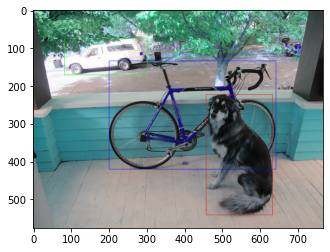

In [16]:
class RandomHorizontalFlip(object):

    """Randomly horizontally flips the Image with the probability *p*

    Parameters
    ----------
    p: float
        The probability with which the image is flipped


    Returns
    -------

    numpy.ndaaray
        Flipped image in the numpy format of shape `HxWxC`

    numpy.ndarray
        Tranformed bounding box co-ordinates of the format `n x 4` where n is
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box

    """

    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img, bboxes):
            img_center = np.array(img.shape[:2])[::-1]/2
            img_center = np.hstack((img_center, img_center))
            if random.random() < self.p:
                img = img[:, ::-1, :]
                bboxes[:, [0, 2]] += 2*(img_center[[0, 2]] - bboxes[:, [0, 2]])

                box_w = abs(bboxes[:, 0] - bboxes[:, 2])

                bboxes[:, 0] -= box_w
                bboxes[:, 2] += box_w

            return img, bboxes

img_, bboxes_ = RandomHorizontalFlip(p)(img.copy(), bboxes.copy())
draw_rect(img_, bboxes_)

In [17]:
class Scale(object):
    """Scales the image    
        
    Bounding boxes which have an area of less than 25% in the remaining in the 
    transformed image is dropped. The resolution is maintained, and the remaining
    area if any is filled by black color.
    
    
    Parameters
    ----------
    scale_x: float
        The factor by which the image is scaled horizontally
        
    scale_y: float
        The factor by which the image is scaled vertically
        
    Returns
    -------
    
    numpy.ndaaray
        Scaled image in the numpy format of shape `HxWxC`
    
    numpy.ndarray
        Tranformed bounding box co-ordinates of the format `n x 4` where n is 
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box
        
    """

    def __init__(self, scale_x = 0.2, scale_y = 0.2):
        self.scale_x = scale_x
        self.scale_y = scale_y
        

    def __call__(self, img, bboxes):
    
        
        #Chose a random digit to scale by 
        
        img_shape = img.shape
        
        
        resize_scale_x = 1 + self.scale_x
        resize_scale_y = 1 + self.scale_y
        
        img=  cv2.resize(img, None, fx = resize_scale_x, fy = resize_scale_y)
        
        bboxes[:,:4] *= [resize_scale_x, resize_scale_y, resize_scale_x, resize_scale_y]
        
        
        
        canvas = np.zeros(img_shape, dtype = np.uint8)
        
        y_lim = int(min(resize_scale_y,1)*img_shape[0])
        x_lim = int(min(resize_scale_x,1)*img_shape[1])
        
        
        canvas[:y_lim,:x_lim,:] =  img[:y_lim,:x_lim,:]
        
        img = canvas
        bboxes = clip_box(bboxes, [0,0,1 + img_shape[1], img_shape[0]], 0.2)

    
        return img, bboxes  

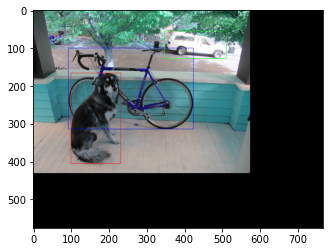

In [18]:
class RandomScale(object):
    """Randomly scales an image    
    
    
    Bounding boxes which have an area of less than 25% in the remaining in the 
    transformed image is dropped. The resolution is maintained, and the remaining
    area if any is filled by black color.
    
    Parameters
    ----------
    scale: float or tuple(float)
        if **float**, the image is scaled by a factor drawn 
        randomly from a range (1 - `scale` , 1 + `scale`). If **tuple**,
        the `scale` is drawn randomly from values specified by the 
        tuple
        
    Returns
    -------
    
    numpy.ndaaray
        Scaled image in the numpy format of shape `HxWxC`
    
    numpy.ndarray
        Tranformed bounding box co-ordinates of the format `n x 4` where n is 
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box
        
    """

    def __init__(self, scale = 0.2, diff = False):
        self.scale = scale

        
        if type(self.scale) == tuple:
            assert len(self.scale) == 2, "Invalid range"
            assert self.scale[0] > -1, "Scale factor can't be less than -1"
            assert self.scale[1] > -1, "Scale factor can't be less than -1"
        else:
            assert self.scale > 0, "Please input a positive float"
            self.scale = (max(-1, -self.scale), self.scale)
        
        self.diff = diff

        

    def __call__(self, img, bboxes):
    
        
        #Chose a random digit to scale by 
        
        img_shape = img.shape
        
        if self.diff:
            scale_x = random.uniform(*self.scale)
            scale_y = random.uniform(*self.scale)
        else:
            scale_x = random.uniform(*self.scale)
            scale_y = scale_x
            
    
        
        resize_scale_x = 1 + scale_x
        resize_scale_y = 1 + scale_y
        
        img=  cv2.resize(img, None, fx = resize_scale_x, fy = resize_scale_y)
        
        bboxes[:,:4] *= [resize_scale_x, resize_scale_y, resize_scale_x, resize_scale_y]
        
        
        
        canvas = np.zeros(img_shape, dtype = np.uint8)
        
        y_lim = int(min(resize_scale_y,1)*img_shape[0])
        x_lim = int(min(resize_scale_x,1)*img_shape[1])
        
        
        canvas[:y_lim,:x_lim,:] =  img[:y_lim,:x_lim,:]
        
        img = canvas
        bboxes = clip_box(bboxes, [0,0,1 + img_shape[1], img_shape[0]], 0.25)
    
    
        return img, bboxes
    
img_, bboxes_ = RandomScale(p)(img.copy(), bboxes.copy())
draw_rect(img_, bboxes_)

In [19]:
class Translate(object):
    """Randomly Translates the image    
    
    
    Bounding boxes which have an area of less than 25% in the remaining in the 
    transformed image is dropped. The resolution is maintained, and the remaining
    area if any is filled by black color.
    
    Parameters
    ----------
    translate: float or tuple(float)
        if **float**, the image is translated by a factor drawn 
        randomly from a range (1 - `translate` , 1 + `translate`). If **tuple**,
        `translate` is drawn randomly from values specified by the 
        tuple
        
    Returns
    -------
    
    numpy.ndaaray
        Translated image in the numpy format of shape `HxWxC`
    
    numpy.ndarray
        Tranformed bounding box co-ordinates of the format `n x 4` where n is 
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box
        
    """

    def __init__(self, translate_x = 0.2, translate_y = 0.2, diff = False):
        self.translate_x = translate_x
        self.translate_y = translate_y

        assert self.translate_x > 0 and self.translate_x < 1
        assert self.translate_y > 0 and self.translate_y < 1
 

    def __call__(self, img, bboxes):        
        #Chose a random digit to scale by 
        img_shape = img.shape
        
        #translate the image
        
        #percentage of the dimension of the image to translate
        translate_factor_x = self.translate_x
        translate_factor_y = self.translate_y
        
            
        canvas = np.zeros(img_shape).astype(np.uint8)

        
        #get the top-left corner co-ordinates of the shifted box 
        corner_x = int(translate_factor_x*img.shape[1])
        corner_y = int(translate_factor_y*img.shape[0])
        
        
        
        #change the origin to the top-left corner of the translated box
        orig_box_cords =  [max(0,corner_y), max(corner_x,0), min(img_shape[0], corner_y + img.shape[0]), min(img_shape[1],corner_x + img.shape[1])]

        
        

        mask = img[max(-corner_y, 0):min(img.shape[0], -corner_y + img_shape[0]), max(-corner_x, 0):min(img.shape[1], -corner_x + img_shape[1]),:]
        canvas[orig_box_cords[0]:orig_box_cords[2], orig_box_cords[1]:orig_box_cords[3],:] = mask
        img = canvas
        
        bboxes[:,:4] += [corner_x, corner_y, corner_x, corner_y]
        
        
        bboxes = clip_box(bboxes, [0,0,img_shape[1], img_shape[0]], 0.25)
        

        

        
        return img, bboxes

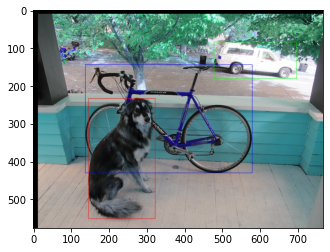

In [20]:
class RandomTranslate(object):
    """Randomly Translates the image    
    
    
    Bounding boxes which have an area of less than 25% in the remaining in the 
    transformed image is dropped. The resolution is maintained, and the remaining
    area if any is filled by black color.
    
    Parameters
    ----------
    translate: float or tuple(float)
        if **float**, the image is translated by a factor drawn 
        randomly from a range (1 - `translate` , 1 + `translate`). If **tuple**,
        `translate` is drawn randomly from values specified by the 
        tuple
        
    Returns
    -------
    
    numpy.ndaaray
        Translated image in the numpy format of shape `HxWxC`
    
    numpy.ndarray
        Tranformed bounding box co-ordinates of the format `n x 4` where n is 
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box
        
    """

    def __init__(self, translate = 0.2, diff = False):
        self.translate = translate
        
        if type(self.translate) == tuple:
            assert len(self.translate) == 2, "Invalid range"  
            assert self.translate[0] > 0 & self.translate[0] < 1
            assert self.translate[1] > 0 & self.translate[1] < 1

        else:
            assert self.translate > 0 and self.translate < 1
            self.translate = (-self.translate, self.translate)
            
        self.diff = diff

    def __call__(self, img, bboxes):        
        #Chose a random digit to scale by 
        img_shape = img.shape
        
        #translate the image
        
        #percentage of the dimension of the image to translate
        translate_factor_x = random.uniform(*self.translate)
        translate_factor_y = random.uniform(*self.translate)
        
        if not self.diff:
            translate_factor_y = translate_factor_x
            
        canvas = np.zeros(img_shape).astype(np.uint8)
    
        corner_x = int(translate_factor_x*img.shape[1])
        corner_y = int(translate_factor_y*img.shape[0])
        
        #change the origin to the top-left corner of the translated box
        orig_box_cords =  [max(0,corner_y), max(corner_x,0), min(img_shape[0], corner_y + img.shape[0]), min(img_shape[1],corner_x + img.shape[1])]
    
    
        mask = img[max(-corner_y, 0):min(img.shape[0], -corner_y + img_shape[0]), max(-corner_x, 0):min(img.shape[1], -corner_x + img_shape[1]),:]
        canvas[orig_box_cords[0]:orig_box_cords[2], orig_box_cords[1]:orig_box_cords[3],:] = mask
        img = canvas
        
        bboxes[:,:4] += [corner_x, corner_y, corner_x, corner_y]
        
        
        bboxes = clip_box(bboxes, [0,0,img_shape[1], img_shape[0]], 0.25)
        
        return img, bboxes

img_, bboxes_ = RandomTranslate(0.2)(img.copy(), bboxes.copy())
draw_rect(img_, bboxes_)

In [21]:
class Rotate(object):
    """Rotates an image    
    
    
    Bounding boxes which have an area of less than 25% in the remaining in the 
    transformed image is dropped. The resolution is maintained, and the remaining
    area if any is filled by black color.
    
    Parameters
    ----------
    angle: float
        The angle by which the image is to be rotated 
        
        
    Returns
    -------
    
    numpy.ndaaray
        Rotated image in the numpy format of shape `HxWxC`
    
    numpy.ndarray
        Tranformed bounding box co-ordinates of the format `n x 4` where n is 
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box
        
    """

    def __init__(self, angle):
        self.angle = angle
        

    def __call__(self, img, bboxes):
        """
        Args:
            img (PIL Image): Image to be flipped.

        Returns:
            PIL Image: Randomly flipped image.
            
            
        """
        
        angle = self.angle
        print(self.angle)
        
        w,h = img.shape[1], img.shape[0]
        cx, cy = w//2, h//2
        
        corners = get_corners(bboxes)
        
        corners = np.hstack((corners, bboxes[:,4:]))

        img = rotate_im(img, angle)
        
        corners[:,:8] = rotate_box(corners[:,:8], angle, cx, cy, h, w)
        
        
        
        
        new_bbox = get_enclosing_box(corners)
        
        
        scale_factor_x = img.shape[1] / w
        
        scale_factor_y = img.shape[0] / h
        
        img = cv2.resize(img, (w,h))
        
        new_bbox[:,:4] /= [scale_factor_x, scale_factor_y, scale_factor_x, scale_factor_y] 
        
        
        bboxes  = new_bbox

        bboxes = clip_box(bboxes, [0,0,w, h], 0.25)
        
        return img, bboxes

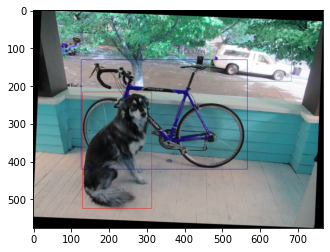

In [22]:
class RandomRotate(object):
    """Randomly rotates an image    
    
    
    Bounding boxes which have an area of less than 25% in the remaining in the 
    transformed image is dropped. The resolution is maintained, and the remaining
    area if any is filled by black color.
    
    Parameters
    ----------
    angle: float or tuple(float)
        if **float**, the image is rotated by a factor drawn 
        randomly from a range (-`angle`, `angle`). If **tuple**,
        the `angle` is drawn randomly from values specified by the 
        tuple
        
    Returns
    -------
    
    numpy.ndaaray
        Rotated image in the numpy format of shape `HxWxC`
    
    numpy.ndarray
        Tranformed bounding box co-ordinates of the format `n x 4` where n is 
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box
        
    """

    def __init__(self, angle = 10, random=True):
        self.random = random
        self.angle = angle
         
        if self.random:
            if type(self.angle) == tuple:
                assert len(self.angle) == 2, "Invalid range"  
                
            else:
                self.angle = (-self.angle, self.angle)
            
    def __call__(self, img, bboxes):
        if self.random:
            angle = random.uniform(*self.angle)
        else:
            angle = self.angle
    
        w,h = img.shape[1], img.shape[0]
        cx, cy = w//2, h//2
    
        img = rotate_im(img, angle)
    
        corners = get_corners(bboxes)
    
        corners = np.hstack((corners, bboxes[:,4:]))
    
    
        corners[:,:8] = rotate_box(corners[:,:8], angle, cx, cy, h, w)
    
        new_bbox = get_enclosing_box(corners)
    
    
        scale_factor_x = img.shape[1] / w
    
        scale_factor_y = img.shape[0] / h
    
        img = cv2.resize(img, (w,h))
    
        new_bbox[:,:4] /= [scale_factor_x, scale_factor_y, scale_factor_x, scale_factor_y] 
    
        bboxes  = new_bbox
    
        bboxes = clip_box(bboxes, [0,0,w, h], 0.25)
    
        return img, bboxes

img_, bboxes_ = RandomRotate(10)(img.copy(), bboxes.copy())
draw_rect(img_, bboxes_)

In [23]:
class Shear(object):
    """Shears an image in horizontal direction   
    
    
    Bounding boxes which have an area of less than 25% in the remaining in the 
    transformed image is dropped. The resolution is maintained, and the remaining
    area if any is filled by black color.
    
    Parameters
    ----------
    shear_factor: float
        Factor by which the image is sheared in the x-direction
       
    Returns
    -------
    
    numpy.ndaaray
        Sheared image in the numpy format of shape `HxWxC`
    
    numpy.ndarray
        Tranformed bounding box co-ordinates of the format `n x 4` where n is 
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box
        
    """

    def __init__(self, shear_factor = 0.2):
        self.shear_factor = shear_factor
        
    
    def __call__(self, img, bboxes):
        
        shear_factor = self.shear_factor
        if shear_factor < 0:
            img, bboxes = HorizontalFlip()(img, bboxes)

        
        M = np.array([[1, abs(shear_factor), 0],[0,1,0]])
                
        nW =  img.shape[1] + abs(shear_factor*img.shape[0])
        
        bboxes[:,[0,2]] += ((bboxes[:,[1,3]])*abs(shear_factor)).astype(int) 
        

        img = cv2.warpAffine(img, M, (int(nW), img.shape[0]))
        
        if shear_factor < 0:
             img, bboxes = HorizontalFlip()(img, bboxes)
             
        
        return img, bboxes

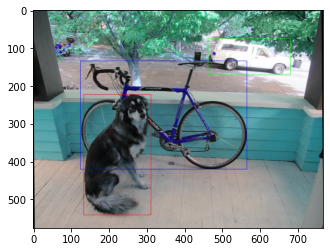

In [24]:
class RandomShear(object):
    """Randomly shears an image in horizontal direction   
    
    
    Bounding boxes which have an area of less than 25% in the remaining in the 
    transformed image is dropped. The resolution is maintained, and the remaining
    area if any is filled by black color.
    
    Parameters
    ----------
    shear_factor: float or tuple(float)
        if **float**, the image is sheared horizontally by a factor drawn 
        randomly from a range (-`shear_factor`, `shear_factor`). If **tuple**,
        the `shear_factor` is drawn randomly from values specified by the 
        tuple
        
    Returns
    -------
    
    numpy.ndaaray
        Sheared image in the numpy format of shape `HxWxC`
    
    numpy.ndarray
        Tranformed bounding box co-ordinates of the format `n x 4` where n is 
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box
        
    """

    def __init__(self, shear_factor = 0.2):
        self.shear_factor = shear_factor
        
        if type(self.shear_factor) == tuple:
            assert len(self.shear_factor) == 2, "Invalid range for scaling factor"   
        else:
            self.shear_factor = (-self.shear_factor, self.shear_factor)
        
        shear_factor = random.uniform(*self.shear_factor)
        
    def __call__(self, img, bboxes):
    
        shear_factor = random.uniform(*self.shear_factor)
    
        w,h = img.shape[1], img.shape[0]
    
        if shear_factor < 0:
            img, bboxes = HorizontalFlip()(img, bboxes)
    
        M = np.array([[1, abs(shear_factor), 0],[0,1,0]])
    
        nW =  img.shape[1] + abs(shear_factor*img.shape[0])
    
        bboxes[:,[0,2]] += ((bboxes[:,[1,3]]) * abs(shear_factor) ).astype(int) 
    
    
        img = cv2.warpAffine(img, M, (int(nW), img.shape[0]))
    
        if shear_factor < 0:
            img, bboxes = HorizontalFlip()(img, bboxes)
    
        img = cv2.resize(img, (w,h))
    
        scale_factor_x = nW / w
    
        bboxes[:,:4] /= [scale_factor_x, 1, scale_factor_x, 1] 
    
    
        return img, bboxes

img_, bboxes_ = RandomShear(0.2)(img.copy(), bboxes.copy())
draw_rect(img_, bboxes_)

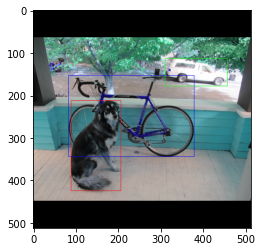

In [25]:
class Resize(object):
    """Resize the image in accordance to `image_letter_box` function in darknet 
    
    The aspect ratio is maintained. The longer side is resized to the input 
    size of the network, while the remaining space on the shorter side is filled 
    with black color. **This should be the last transform**
    
    
    Parameters
    ----------
    inp_dim : tuple(int)
        tuple containing the size to which the image will be resized.
        
    Returns
    -------
    
    numpy.ndaaray
        Sheared image in the numpy format of shape `HxWxC`
    
    numpy.ndarray
        Resized bounding box co-ordinates of the format `n x 4` where n is 
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box
        
    """
    
    def __init__(self, inp_dim):
        self.inp_dim = inp_dim
        
    def __call__(self, img, bboxes):
        w,h = img.shape[1], img.shape[0]
        img = letterbox_image(img, self.inp_dim)
    
    
        scale = min(self.inp_dim/h, self.inp_dim/w)
        bboxes[:,:4] *= (scale)
    
        new_w = scale*w
        new_h = scale*h
        inp_dim = self.inp_dim   
    
        del_h = (inp_dim - new_h)/2
        del_w = (inp_dim - new_w)/2
    
        add_matrix = np.array([[del_w, del_h, del_w, del_h]]).astype(int)
    
        bboxes[:,:4] += add_matrix
    
        img = img.astype(np.uint8)
    
        return img, bboxes 

img_, bboxes_ = Resize(512)(img.copy(), bboxes.copy())
draw_rect(img_, bboxes_)

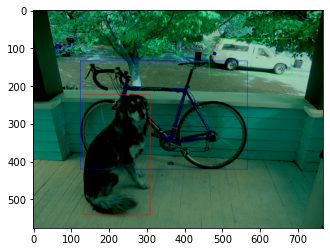

In [26]:
class RandomHSV(object):
    """HSV Transform to vary hue saturation and brightness
    
    Hue has a range of 0-179
    Saturation and Brightness have a range of 0-255. 
    Chose the amount you want to change thhe above quantities accordingly. 
    
    
    
    
    Parameters
    ----------
    hue : None or int or tuple (int)
        If None, the hue of the image is left unchanged. If int, 
        a random int is uniformly sampled from (-hue, hue) and added to the 
        hue of the image. If tuple, the int is sampled from the range 
        specified by the tuple.   
        
    saturation : None or int or tuple(int)
        If None, the saturation of the image is left unchanged. If int, 
        a random int is uniformly sampled from (-saturation, saturation) 
        and added to the hue of the image. If tuple, the int is sampled
        from the range  specified by the tuple.   
        
    brightness : None or int or tuple(int)
        If None, the brightness of the image is left unchanged. If int, 
        a random int is uniformly sampled from (-brightness, brightness) 
        and added to the hue of the image. If tuple, the int is sampled
        from the range  specified by the tuple.   
    
    Returns
    -------
    
    numpy.ndaaray
        Transformed image in the numpy format of shape `HxWxC`
    
    numpy.ndarray
        Resized bounding box co-ordinates of the format `n x 4` where n is 
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box
        
    """
    
    def __init__(self, hue = None, saturation = None, brightness = None):
        if hue:
            self.hue = hue 
        else:
            self.hue = 0
            
        if saturation:
            self.saturation = saturation 
        else:
            self.saturation = 0
            
        if brightness:
            self.brightness = brightness
        else:
            self.brightness = 0
            
        if type(self.hue) != tuple:
            self.hue = (-self.hue, self.hue)
            
        if type(self.saturation) != tuple:
            self.saturation = (-self.saturation, self.saturation)
        
        if type(brightness) != tuple:
            self.brightness = (-self.brightness, self.brightness)
    
    def __call__(self, img, bboxes):

        hue = random.randint(*self.hue)
        saturation = random.randint(*self.saturation)
        brightness = random.randint(*self.brightness)
        
        img = img.astype(int)
        
        a = np.array([hue, saturation, brightness]).astype(int)
        img += np.reshape(a, (1,1,3))
        
        img = np.clip(img, 0, 255)
        img[:,:,0] = np.clip(img[:,:,0],0, 179)
        
        img = img.astype(np.uint8)

        return img, bboxes
    
img_, bboxes_ = RandomHSV(100,100,100)(img.copy(), bboxes.copy())
draw_rect(img_, bboxes_)

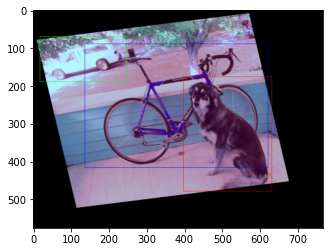

In [27]:
class Sequence(object):

    """Initialise Sequence object
    
    Apply a Sequence of transformations to the images/boxes.
    
    Parameters
    ----------
    augemnetations : list 
        List containing Transformation Objects in Sequence they are to be 
        applied
    
    probs : int or list 
        If **int**, the probability with which each of the transformation will 
        be applied. If **list**, the length must be equal to *augmentations*. 
        Each element of this list is the probability with which each 
        corresponding transformation is applied
    
    Returns
    -------
    
    Sequence
        Sequence Object 
        
    """
    def __init__(self, augmentations, probs = 1):

        
        self.augmentations = augmentations
        self.probs = probs
        
    def __call__(self, images, bboxes):
        for i, augmentation in enumerate(self.augmentations):
            if type(self.probs) == list:
                prob = self.probs[i]
            else:
                prob = self.probs
                
            if random.random() < prob:
                images, bboxes = augmentation(images, bboxes)
        return images, bboxes

seq = Sequence([RandomHSV(40, 40, 30), RandomHorizontalFlip(), RandomScale(), RandomTranslate(),
                    RandomRotate(10), RandomShear()])
img_, bboxes_ = seq(img.copy(), bboxes.copy())
draw_rect(img_, bboxes_)

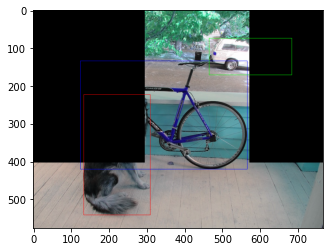

In [28]:
class GridMask(object):
    def __init__(self, use_h, use_w, rotate=1, offset=False, ratio=.5, mode=0, prob=.7):
        self.use_h = use_h
        self.use_w = use_w
        self.rotate = rotate
        self.offset = offset
        self.ratio = ratio
        self.mode = mode
        self.st_prob = prob
        self.prob = prob

    def set_prob(self, prob=.5):
        self.prob = prob

    def __call__(self, img, bboxes):
        if np.random.rand() > self.prob:
            return img, bboxes
        h = img.shape[0]
        w = img.shape[1]
        self.d1 = 2
        self.d2 = min(h, w)
        hh = int(1.5 * h)
        ww = int(1.5 * w)
        d = np.random.randint(self.d1, self.d2)
        # d = self.d
        #        self.l = int(d*self.ratio+0.5)
        if self.ratio == 1:
            self.l = np.random.randint(1, d)
        else:
            self.l = min(max(int(d * self.ratio + 0.5), 1), d - 1)
        mask = np.ones((hh, ww), np.float32)
        st_h = np.random.randint(d)
        st_w = np.random.randint(d)
        if self.use_h:
            for i in range(hh // d):
                s = d * i + st_h
                t = min(s + self.l, hh)
                mask[s:t, :] *= 0
        if self.use_w:
            for i in range(ww // d):
                s = d * i + st_w
                t = min(s + self.l, ww)
                mask[:, s:t] *= 0

        r = np.random.randint(self.rotate)
        mask = Image.fromarray(np.uint8(mask))
        mask = mask.rotate(r)
        mask = np.asarray(mask)
        #        mask = 1*(np.random.randint(0,3,[hh,ww])>0)
        mask = mask[(hh - h) // 2:(hh - h) // 2 + h, (ww - w) // 2:(ww - w) // 2 + w]

        if self.mode == 1:
            mask = 1 - mask
        mask = np.expand_dims(mask.astype(np.float), axis=2)
        mask = np.tile(mask, [1, 1, 3])
        mask = mask.astype(np.uint8)
        if self.offset:
            offset = np.float(2 * (np.random.rand(h, w) - 0.5))
            offset = (1 - mask) * offset
            img = img * mask + offset
        else:
            img = img * mask
        return img, bboxes

img_, bboxes_ = GridMask(True, True, 1, 0, 0.5, 1, 1.0)(img.copy(), bboxes.copy())
draw_rect(img_, bboxes_)

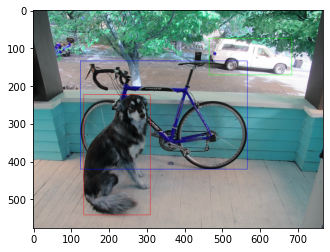

In [29]:
class SmallObjectAugmentation(object):
    def __init__(self, thresh=256*256, prob=.7, copy_times=3, epochs=30, all_objects=False, one_object=False):
        """
        sample = {'img':img, 'annot':annots}
        img = [height, width, 3]
        annot = [xmin, ymin, xmax, ymax, label]
        thresh：the detection threshold of the small object. If annot_h * annot_w < thresh, the object is small
        prob: the prob to do small object augmentation
        epochs: the epochs to do
        """
        self.thresh = thresh
        self.prob = prob
        self.copy_times = copy_times
        self.epochs = epochs
        self.all_objects = all_objects
        self.one_object = one_object
        if self.all_objects or self.one_object:
            self.copy_times = 1

    def issmallobject(self, h, w):
        if h * w <= self.thresh:
            return True
        else:
            return False

    def compute_overlap(self, annot_a, annot_b):
        if annot_a is None: return False
        left_max = max(annot_a[0], annot_b[0])
        top_max = max(annot_a[1], annot_b[1])
        right_min = min(annot_a[2], annot_b[2])
        bottom_min = min(annot_a[3], annot_b[3])
        inter = max(0, (right_min-left_max)) * max(0, (bottom_min-top_max))
        if inter != 0:
            return True
        else:
            return False

    def donot_overlap(self, new_annot, annots):
        for annot in annots:
            if self.compute_overlap(new_annot, annot): return False
        return True

    def create_copy_annot(self, h, w, annot, annots):
        annot = annot.astype(np.int)
        annot_h, annot_w = annot[3] - annot[1], annot[2] - annot[0]
        for epoch in range(self.epochs):
            random_x, random_y = np.random.randint(int(annot_w / 2), int(w - annot_w / 2)), \
                                 np.random.randint(int(annot_h / 2), int(h - annot_h / 2))
            xmin, ymin = random_x - annot_w / 2, random_y - annot_h / 2
            xmax, ymax = xmin + annot_w, ymin + annot_h
            if xmin < 0 or xmax > w or ymin < 0 or ymax > h:
                continue
            new_annot = np.array([xmin, ymin, xmax, ymax, annot[4]]).astype(np.int)

            if self.donot_overlap(new_annot, annots) is False:
                continue

            return new_annot
        return None

    def add_patch_in_img(self, annot, copy_annot, image):
        copy_annot = copy_annot.astype(np.int)
        image[annot[1]:annot[3], annot[0]:annot[2], :] = image[copy_annot[1]:copy_annot[3], copy_annot[0]:copy_annot[2], :]
        return image

    def __call__(self, img, bboxes):
        if self.all_objects and self.one_object: return img, bboxes
        if np.random.rand() > self.prob: return img, bboxes

        img, annots = img, bboxes
        h, w= img.shape[0], img.shape[1]

        small_object_list = list()
        for idx in range(annots.shape[0]):
            annot = annots[idx]
            annot_h, annot_w = annot[3] - annot[1], annot[2] - annot[0]
            if self.issmallobject(annot_h, annot_w):
                small_object_list.append(idx)

        l = len(small_object_list)
        # No Small Object
        if l == 0: return img, bboxes

        # Refine the copy_object by the given policy
        # Policy 2:
        copy_object_num = np.random.randint(0, l)
        # Policy 3:
        if self.all_objects:
            copy_object_num = l
        # Policy 1:
        if self.one_object:
            copy_object_num = 1

        random_list = random.sample(range(l), copy_object_num)
        annot_idx_of_small_object = [small_object_list[idx] for idx in random_list]
        select_annots = annots[annot_idx_of_small_object, :]
        annots = annots.tolist()
        for idx in range(copy_object_num):
            annot = select_annots[idx]
            annot_h, annot_w = annot[3] - annot[1], annot[2] - annot[0]

            if self.issmallobject(annot_h, annot_w) is False: continue

            for i in range(self.copy_times):
                new_annot = self.create_copy_annot(h, w, annot, annots,)
                if new_annot is not None:
                    img = self.add_patch_in_img(new_annot, annot, img)
                    annots.append(new_annot)

        return img, annots
    
img_, bboxes_ = SmallObjectAugmentation()(img.copy(), bboxes.copy())
draw_rect(img_, np.array(bboxes_))

In [30]:
import torchvision.transforms.functional as F

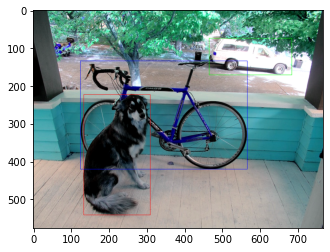

In [31]:
class Adjust_Contrast(object):
    def __init__(self, contrast_factor=1.5):
        self.contrast_factor = contrast_factor
        
    def __call__(self, img, bboxes):
        if type(img) == np.ndarray:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = Image.fromarray(img)
    
        img = F.adjust_contrast(img,self.contrast_factor)
        img = np.array(img) 
        img = img[:, :, ::-1].copy() 
    
        return img, bboxes 

img_, bboxes_ = Adjust_Contrast(1.2)(img.copy(), bboxes.copy())
draw_rect(img_, np.array(bboxes_))

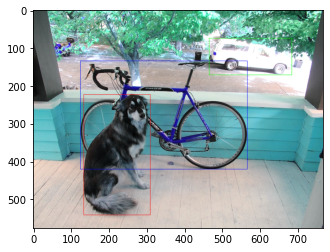

In [32]:
class Adjust_Brightness(object):
    def __init__(self, brightness_factor=1.5):
        self.brightness_factor = brightness_factor
        
    def __call__(self, img, bboxes):
        if type(img) == np.ndarray:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = Image.fromarray(img)
    
        img = F.adjust_brightness(img,self.brightness_factor)
        img = np.array(img) 
        img = img[:, :, ::-1].copy() 
        return img, bboxes

img_, bboxes_ = Adjust_Brightness(1.2)(img.copy(), bboxes.copy())
draw_rect(img_, np.array(bboxes_))

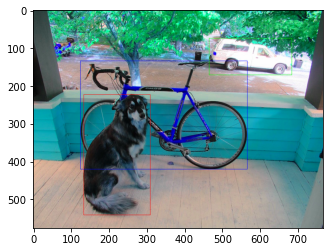

In [33]:
class Adjust_Saturation(object):
    def __init__(self, saturation_factor=1.5):
        self.saturation_factor = saturation_factor
        
    def __call__(self, img, bboxes):
        if type(img) == np.ndarray:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = Image.fromarray(img)
    
        img = F.adjust_saturation(img,self.saturation_factor)
        img = np.array(img) 
        img = img[:, :, ::-1].copy() 
        return img, bboxes

img_, bboxes_ = Adjust_Saturation(2)(img.copy(), bboxes.copy())
draw_rect(img_, np.array(bboxes_))

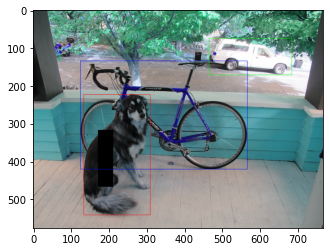

In [34]:
class Cutout(object):
    def __init__(self, amount=.3):
        self.amount = amount
        
    def __call__(self, img, bboxes):
        img = img.copy()
        bboxes = list(bboxes.copy())
        ran_select = random.sample(bboxes, round(self.amount*len(bboxes)))

        for box in ran_select:
            x1 = int(box[0])
            y1 = int(box[1])
            x2 = int(box[2])
            y2 = int(box[3])
            mask_w = int((x2 - x1)*random.uniform(0, 0.7))
            mask_h = int((y2 - y1)*random.uniform(0, 0.7))
            mask_x1 = random.randint(x1, x2 - mask_w)
            mask_y1 = random.randint(y1, y2 - mask_h)
            mask_x2 = mask_x1 + mask_w
            mask_y2 = mask_y1 + mask_h
            
            img[mask_y1:mask_y2, mask_x1:mask_x2, :] = 0
        return img, bboxes

img_, bboxes_ = Cutout(0.3)(img.copy(), bboxes.copy())
draw_rect(img_, np.array(bboxes_))

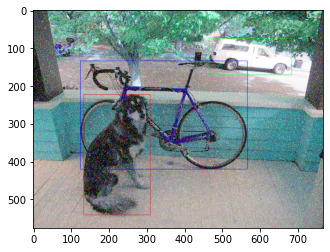

In [35]:
class Noisy(object):
    def __init__(self, noise_type="gauss"):
        self.noise_type = noise_type
        
    def __call__(self, img, bboxes):
        if self.noise_type == "gauss":
            image=img.copy() 
            mean=0
            st=0.7
            gauss = np.random.normal(mean,st,image.shape)
            gauss = gauss.astype('uint8')
            image = cv2.add(image,gauss)
            return image, bboxes
    
        elif self.noise_type == "sp":
            image=img.copy() 
            prob = 0.05
            if len(image.shape) == 2:
                black = 0
                white = 255            
            else:
                colorspace = image.shape[2]
                if colorspace == 3:  # RGB
                    black = np.array([0, 0, 0], dtype='uint8')
                    white = np.array([255, 255, 255], dtype='uint8')
                else:  # RGBA
                    black = np.array([0, 0, 0, 255], dtype='uint8')
                    white = np.array([255, 255, 255, 255], dtype='uint8')
            probs = np.random.random(image.shape[:2])
            image[probs < (prob / 2)] = black
            image[probs > 1 - (prob / 2)] = white
            return image, bboxes

img_, bboxes_ = Noisy("gauss")(img.copy(), bboxes.copy())
draw_rect(img_, np.array(bboxes_))

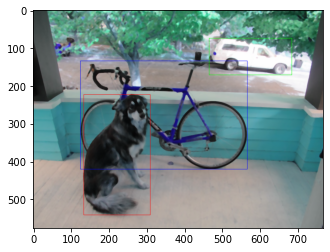

In [36]:
class Filters(object):
    def __init__(self):
        pass
    def __call__(self, img, bboxes):
        filter_list = ["blur", "gaussian", "median"]
        f_type = random.choice(filter_list)
        temp = int(img.shape[0]/100)
        if temp%2 == 1: 
            fsize = temp 
        else:
            fsize = temp +1
    
        if f_type == "blur":
            image=img.copy()
            return cv2.blur(image,(fsize,fsize)), bboxes
        elif f_type == "gaussian":
            image=img.copy()
            return cv2.GaussianBlur(image, (fsize, fsize), 0), bboxes
        elif f_type == "median":
            image=img.copy()
            return cv2.medianBlur(image, fsize), bboxes

img_, bboxes_ = Filters()(img.copy(), bboxes.copy())
draw_rect(img_, np.array(bboxes_))

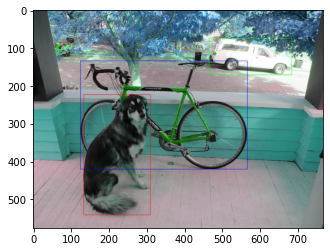

In [37]:
class Lighting_Noise(object):
    def __init__(self):
        pass
        
    def __call__(self, img, bboxes):
        img = img.copy()
        perms = ((0, 1, 2), (0, 2, 1), (1, 0, 2), 
                (1, 2, 0), (2, 0, 1), (2, 1, 0))
        swap = perms[random.randint(0, len(perms)- 1)]
        
        if type(img) == np.ndarray:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = Image.fromarray(img)
        
        img = F.to_tensor(img)
        img = img[swap, :, :]
        img = F.to_pil_image(img)
        img = np.array(img) 
        img = img[:, :, ::-1].copy() 
        
        return img, bboxes

img_, bboxes_ = Lighting_Noise()(img.copy(), bboxes.copy())
draw_rect(img_, np.array(bboxes_))

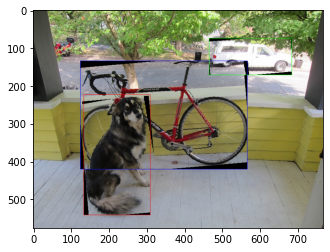

In [38]:
class Rotate_Only_Bboxes(object):
    def __init__(self, angle=5):
        self.angle = angle
        
    def __call__(self, img, bboxes):
        new_image = img.copy()
        boxes = bboxes.copy()
        new_image = F.to_tensor(new_image)
        for i in range(boxes.shape[0]):
            x_min, y_min, x_max, y_max, id = map(int, boxes[i])
            bbox = new_image[:,  y_min:y_max+1, x_min:x_max+1]
            bbox = F.to_pil_image(bbox)
            bbox = bbox.rotate(self.angle)
            
            new_image[:,y_min:y_max+1, x_min:x_max+1] = F.to_tensor(bbox)
            img = F.to_pil_image(new_image)
            img = np.array(img) 
            img = img[:, :, ::-1].copy() 
        return img , boxes

img_, bboxes_ = Rotate_Only_Bboxes(5)(img.copy(), bboxes.copy())
draw_rect(img_, np.array(bboxes_))

In [39]:
import torch
path_img2 = './assets/voc/sample2.jpg'
img2 = cv2.imread(path_img2)

path_xml2 = './assets/voc/sample2.xml'
bboxes2 = get_info_bbox(path_xml2, label_mapping)

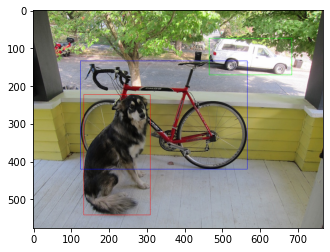

In [40]:
class Mixup(object):
    def __init__(self, lambd=.3):
        self.lambd = lambd
        
    def __call__(self, img1, bboxes1, img2, bboxes2):
        img1 = F.to_tensor(img1)  #Tensor
        img2 = F.to_tensor(img2)  #Tensor
        
        mixup_width = max(img1.shape[2], img2.shape[2])
        mix_up_height = max(img1.shape[1], img2.shape[1])
        
        mix_img = torch.zeros(3, mix_up_height, mixup_width)
        mix_img[:, :img1.shape[1], :img1.shape[2]] = img1 * self.lambd
        mix_img[:, :img2.shape[1], :img2.shape[2]] += img2 * (1. - self.lambd)
        
        img = F.to_pil_image(mix_img)
        img = np.array(img) 
        img = img[:, :, ::-1].copy()

        mix_bboxes = np.concatenate((bboxes1, bboxes2))
    
        return img, mix_bboxes

img_, bboxes_ = Mixup(.3)(img.copy(), bboxes.copy(), img2.copy(), bboxes2.copy())
draw_rect(img_, np.array(bboxes_))

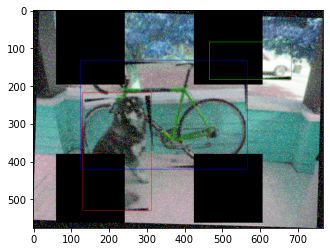

In [41]:
seq = Sequence([Rotate_Only_Bboxes(5), Lighting_Noise(), Filters(),RandomRotate(10), Noisy("gauss"), GridMask(True, True, 1, 0, 0.5, 1, 1.0)])
img_, bboxes_ = seq(img.copy(), bboxes.copy())
draw_rect(img_, bboxes_)